# CNN_Skin_Cancer_Assignment

## Problem statement: 
- To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Project Pipeline
1. Data Reading/Data Understanding 
2. Dataset Creation
3. Dataset visualisation 
4. Model Building & training 
    - Write your findings after the model fit, see if there is evidence of model overfit or underfit
6. Choose an appropriate data augmentation strategy to resolve underfitting/overfitting 
7. Model Building & training on the augmented data :
    - Write your findings after the model fit, see if the earlier issue is resolved or not?
8. Class distribution
9. Handling class imbalances
10. Model Building & training on the rectified class imbalance data 

### This notbook is build and tested in google colab

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

### Step 1 - Data Reading/Data Understanding
- Importing Skin Cancer Data
- Take necessary actions to read the data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [55]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir = 'gdrive/MyDrive/Data'
data_dir_train = pathlib.Path("gdrive/MyDrive/Data/Train")
data_dir_test = pathlib.Path("gdrive/MyDrive/Data/Test")

In [56]:
# print total number of train and test images

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total number of image in Train folder:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total number of image in Test folder:", image_count_test)

Total number of image in Train folder: 2249
Total number of image in Test folder: 118


### Step2 - Dataset Creation
### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [57]:
# defining parameter

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [58]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=False, seed=123, validation_split=0.2, subset="training",
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [59]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=False, seed=123, validation_split=0.2, subset="validation",
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [60]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names

print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Step 3 - Dataset visualisation 
#### Create a code to visualize one instance of all the nine classes present in the dataset

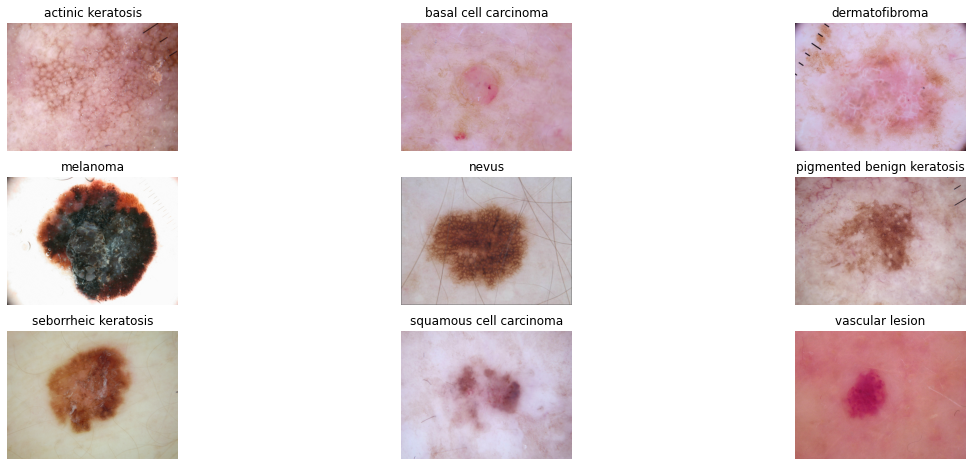

In [61]:
# visualizing one instance of all the nine classes present in the dataset

from os.path import join
from os import listdir
import matplotlib.image as mpimg

num_classes = len(class_names)
image_indexes = [0]
selected_image_file_paths = dict()
for classification in class_names:
    image_directory = join(data_dir_train, classification)
    image_file_names = listdir(image_directory)
    selected_image_file_paths[classification] = [join(image_directory, image_file_names[i]) for i in image_indexes]

plt.figure(figsize=(20, 25))
    
for i,classification in enumerate(class_names):
    for j,image in enumerate(selected_image_file_paths[classification]):
        image_number = (i * len(image_indexes)) + j + 1
        ax = plt.subplot(num_classes,3,image_number)
        plt.title(classification)
        plt.axis("off")
        plt.imshow(mpimg.imread(image))

In [62]:
# image_batch and label_batch

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [63]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Step 4 - Model Building & training 
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [64]:
### Define CNN model

num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=image_batch.shape[1:]),
    
    tf.keras.layers.Conv2D(32,3,activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
   
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


### Compile the model

Choose an appropirate optimiser and loss function for model training 

In [65]:
### choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
# View the summary of all layers

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [67]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 14s 66ms/step - loss: 2.0045 - accuracy: 0.2133 - val_loss: 4.6935 - val_accuracy: 0.0000e+00
Epoch 2/20
57/57 [==============================] - 2s 34ms/step - loss: 1.8320 - accuracy: 0.1444 - val_loss: 5.1592 - val_accuracy: 0.1158
Epoch 3/20
57/57 [==============================] - 2s 33ms/step - loss: 1.7477 - accuracy: 0.2156 - val_loss: 5.9230 - val_accuracy: 0.0000e+00
Epoch 4/20
57/57 [==============================] - 2s 33ms/step - loss: 1.7584 - accuracy: 0.2733 - val_loss: 6.3212 - val_accuracy: 0.0000e+00
Epoch 5/20
57/57 [==============================] - 2s 33ms/step - loss: 1.8122 - accuracy: 0.2172 - val_loss: 7.7647 - val_accuracy: 0.1158
Epoch 6/20
57/57 [==============================] - 2s 33ms/step - loss: 1.7117 - accuracy: 0.2294 - val_loss: 8.1515 - val_accuracy: 0.1069
Epoch 7/20
57/57 [==============================] - 2s 32ms/step - loss: 1.6991 - accuracy: 0.2361 - val_loss: 6.1488 - val_accuracy: 0.0846


### Visualizing training results

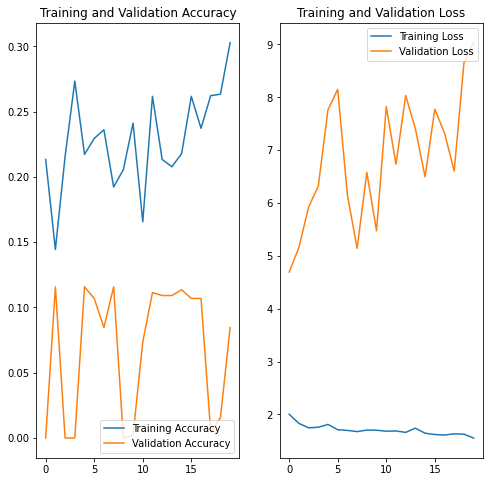

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings:-

- Overall model accuracy is too low
- Model is clearly overfitting. 
- There is significance difference between training and validation accuracy.
- Validation loss is significantly high
- The main reason for this is sample size is low for train and validation. Number of sample for validation quite low.

### Step 5 - data augmentation strategy to resolve underfitting/overfitting

(180, 180, 3)


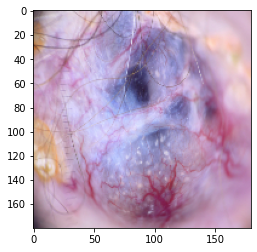

In [69]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# First Let's retrieve an image from the dataset and use it to demonstrate data augmentation

image, label = next(iter(train_ds))
print(image[0].shape)
plt.imshow(image[0].numpy().astype("uint8"))



In [70]:
# Data augmentation
# will can use preprocessing layers for data augmentation.

# Let's create a few preprocessing layers and apply them repeatedly to the same image

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [71]:
# Add the image to a batch

image = tf.expand_dims(image, 0)

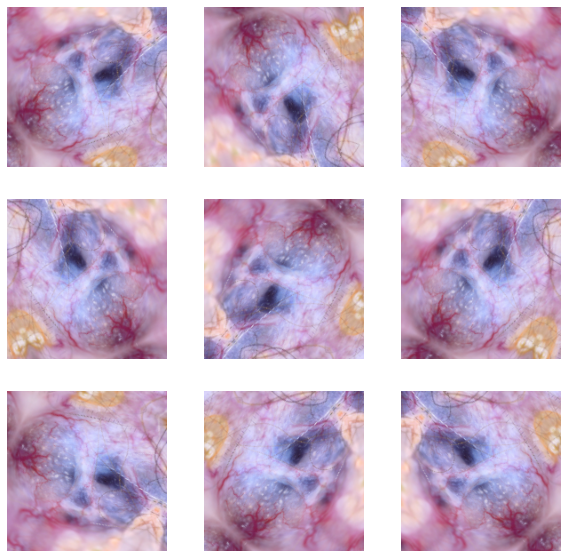

In [72]:
# visualize how your augmentation strategy works for one instance of training image

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

### Step 7 -  Model Building & training on the augmented data
- Create the model, compile and train the model

In [73]:
## Defining the model. Using dropout

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=image_batch.shape[1:]),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    
    tf.keras.layers.Conv2D(32,3,activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
   
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [74]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [75]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 3s 37ms/step - loss: 2.1555 - accuracy: 0.1128 - val_loss: 3.8595 - val_accuracy: 0.0000e+00
Epoch 2/20
57/57 [==============================] - 2s 34ms/step - loss: 1.8439 - accuracy: 0.2111 - val_loss: 4.1648 - val_accuracy: 0.0000e+00
Epoch 3/20
57/57 [==============================] - 2s 34ms/step - loss: 1.7467 - accuracy: 0.1850 - val_loss: 12.0632 - val_accuracy: 0.0000e+00
Epoch 4/20
57/57 [==============================] - 2s 34ms/step - loss: 1.7331 - accuracy: 0.1867 - val_loss: 4.1210 - val_accuracy: 0.1158
Epoch 5/20
57/57 [==============================] - 2s 35ms/step - loss: 2.7482 - accuracy: 0.2089 - val_loss: 4.4286 - val_accuracy: 0.0000e+00
Epoch 6/20
57/57 [==============================] - 2s 34ms/step - loss: 1.7402 - accuracy: 0.1528 - val_loss: 5.5039 - val_accuracy: 0.0000e+00
Epoch 7/20
57/57 [==============================] - 2s 34ms/step - loss: 1.7295 - accuracy: 0.1922 - val_loss: 6.7392 - val_accuracy:

### Visualizing the results

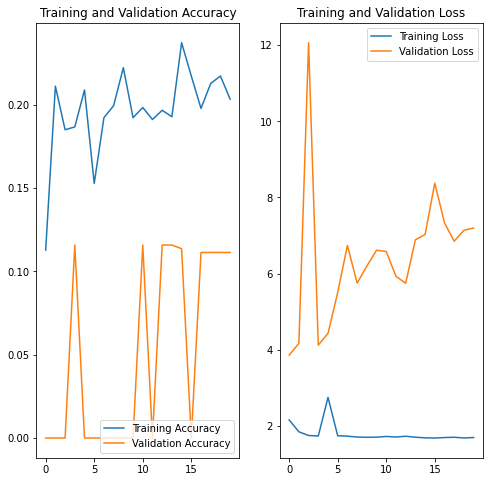

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings :-  

- There is some improvement in the sense that model is no longer overfitting. 
- Using data augmentation strategy and dropout helped address overfitting.
- Validation loss has reduced. But the train and validation accuracy is still very low. 
- This may be because of class imbalance issue.

### Step 8 - Finidng Class distribution

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [77]:
## Class distribution 

num_classes = len(class_names)
image_indexes = [0]
selected_image_file_paths = dict()
for classification in class_names:
    image_directory = join(data_dir_train, classification)
    image_file_names = listdir(image_directory)
    print("number of samples for class:" +" " + classification + " - " + str(len(image_file_names)))

number of samples for class: actinic keratosis - 114
number of samples for class: basal cell carcinoma - 376
number of samples for class: dermatofibroma - 95
number of samples for class: melanoma - 438
number of samples for class: nevus - 357
number of samples for class: pigmented benign keratosis - 472
number of samples for class: seborrheic keratosis - 77
number of samples for class: squamous cell carcinoma - 181
number of samples for class: vascular lesion - 139


#### Findings about class distribution: 
- As per above it's evident the class is not evenly distributed. There is class imbalance in the dataset
#### - Which class has the least number of samples?
- `seborrheic keratosis` class is having least number of samples 
#### - Which classes dominate the data in terms proportionate number of samples?
- `pigmented benign keratosis`, `melanoma`, `basal cell carcinoma` and  `nevus` classes each having more than 350 sample dominate the data 



### Step 9 - Handling class imbalances

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

#### Before using `Augmentor` let's first create the dataframe (original_df) with original number of samples in each class.

In [78]:
# define path list

from glob import glob

path_list_orig = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list_orig)

2249

In [79]:
# create original_df with all the images before adding data augmentation images

lesion_list_orig = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]

dataframe_dict_orig = dict(zip(path_list_orig, lesion_list_orig))

original_df = pd.DataFrame(list(dataframe_dict_orig.items()),columns = ['Path','Label'])


In [80]:
# value count in original_df for each class

original_df['Label'].value_counts()

pigmented benign keratosis    472
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [81]:
# install Augmentor

!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [82]:
# adding 500 samples per class

path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C2410CD10>: 100%|██████████| 500/500 [00:18<00:00, 26.86 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2CF5259E10>: 100%|██████████| 500/500 [00:18<00:00, 27.42 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C981B2FD0>:   0%|          | 1/500 [00:00<01:19,  6.25 Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2CF51E1150>: 100%|██████████| 500/500 [00:19<00:00, 25.21 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F2C240F6C50>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x722 at 0x7F2C960FAF90>: 100%|██████████| 500/500 [01:24<00:00,  5.94 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 472 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C961A0D50>: 100%|██████████| 500/500 [00:19<00:00, 25.88 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2C8DCAD0D0>: 100%|██████████| 500/500 [00:40<00:00, 12.35 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2CE003DF10>: 100%|██████████| 500/500 [00:18<00:00, 26.72 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2C98380A50>:   0%|          | 1/500 [00:00<00:53,  9.28 Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2CF5179390>: 100%|██████████| 500/500 [00:19<00:00, 26.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [83]:
# image count in the output folder after adding augmented images

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Total number of augmented images: ", image_count_train)

Total number of augmented images:  4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [84]:
# Path list new for augmented image added in output folder

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [85]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [86]:
# create new data fram df2

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

# append the new data frame  with original data frame

new_df = original_df.append(df2)


In [87]:
# value count showing number of sample in each class after adding augmented images

new_df['Label'].value_counts()

pigmented benign keratosis    972
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Step 10 - Model Building & training on the rectified class imbalance data 

In [88]:
batch_size = 32
img_height = 180
img_width = 180

####  Creating training dataset

In [89]:
# define train data set having both original and augmented images

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Creating a validation dataset

In [90]:
# define validation data set having both original and augmented images

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### Creating final model (make sure to include normalization)

In [91]:
## Defining the model, using Batch normalisation and dropout


model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=image_batch.shape[1:]),
    
    tf.keras.layers.Conv2D(32,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,3,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

#### Compile the model (Choose optimizer and loss function appropriately)

In [92]:
## your code goes here

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Training the model

In [93]:
epochs = 30

## Your code goes here, use 30 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 194ms/step - loss: 3.4069 - accuracy: 0.2946 - val_loss: 7.7968 - val_accuracy: 0.1408
Epoch 2/30
169/169 [==============================] - 33s 189ms/step - loss: 1.6550 - accuracy: 0.3835 - val_loss: 9.8872 - val_accuracy: 0.2024
Epoch 3/30
169/169 [==============================] - 33s 190ms/step - loss: 1.5969 - accuracy: 0.3989 - val_loss: 3.0804 - val_accuracy: 0.3573
Epoch 4/30
169/169 [==============================] - 33s 190ms/step - loss: 1.4736 - accuracy: 0.4359 - val_loss: 1.3755 - val_accuracy: 0.5041
Epoch 5/30
169/169 [==============================] - 33s 188ms/step - loss: 1.3829 - accuracy: 0.4685 - val_loss: 1.2754 - val_accuracy: 0.5308
Epoch 6/30
169/169 [==============================] - 33s 187ms/step - loss: 1.3206 - accuracy: 0.4972 - val_loss: 1.1432 - val_accuracy: 0.5789
Epoch 7/30
169/169 [==============================] - 33s 187ms/step - loss: 1.2608 - accuracy: 0.5089 - val_loss: 5.5353 - val_ac

#### Visualize the model results

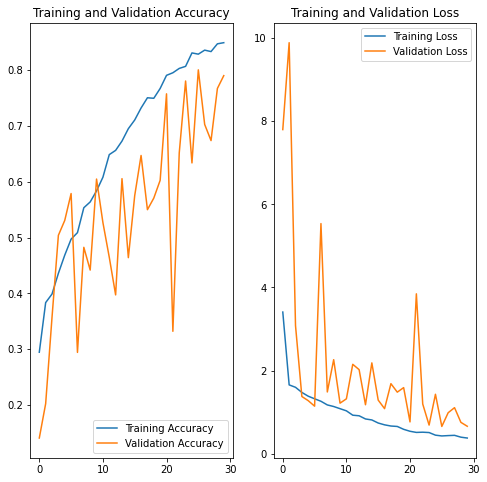

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analyzing the results
- After adding 500 augmented image in each class model accuracy has increased significantly. Earlier Train/Validation accuracy was too low
- Model is no longer overfitting. Train and validation accuracy has increased and both the accuracy is now comprable.
- Loss has reduced considerably. Both train and validation accuracy is now close to zero
- class rebalance has definately helped. 